In [0]:
# required imports
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
#project_path = 'include pathe to where your notebook is located on the drive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# create transforms to load the images, nothing much is needed here. 

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [4]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10('../data', train=True,
                                        download=True, transform=transform_train)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10('../data', train=True,
                                        download=True, transform=transform_test)

# load the test data
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 frog horse   dog truck


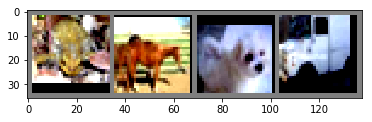

In [5]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [6]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
test_size = len(testset)
#loader_size = len(trainloader)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

#print(loader_size)

print(total_size, test_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:total_size]

50000 50000 12500 25000 37500


In [7]:
train_batch_size = 128 # pick your own
test_batch_size = 64

#train_batch_size = 128 # maybe only need one
#test_batch_size = 64

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
shadow_out_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, sampler=target_train_sampler)

target_out_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, sampler=target_out_sampler)

print(len(shadow_train_loader))
print(len(shadow_out_loader))
print(len(target_train_loader))
print(len(target_out_loader))


98
196
98
196


In [0]:
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) 
# output of fc is 10 because we have 10 classes!



class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8192, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [9]:
# initalize a target model and train it
epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

target_model = CNN()
target_model.to(device)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss
optimizer = optim.Adam(target_model.parameters(), lr = .001)# try Adam VS SGD

# let the magic begin
for epoch in range(epochs):  

    running_loss = 0.0
    
    for i, data in enumerate(target_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        #print(inputs.shape)
        outputs = target_model(inputs)
                       
        # calculate loss
        loss = criterion(outputs, labels)
                       
        # backwards propogation
        loss.backward()       
        
       

        # calculate gradients
        optimizer.step()
        # updaate weights in backprop
                       
                       
        running_loss += loss.data
        # print statistics
        
    ##train_accuracy = calculate_accuracy(trainloader)
    ##test_accuracy = calculate_accuracy(testloader)

    running_loss_normal = running_loss / len(target_train_loader)
    print("Running Loss: %f , Normalized: %f" % (running_loss, running_loss_normal))

    #print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
        
        

print('Finished Training the Target model...')

Running Loss: 185.574234 , Normalized: 1.893615
Running Loss: 151.831146 , Normalized: 1.549297
Running Loss: 138.282974 , Normalized: 1.411051
Running Loss: 126.807106 , Normalized: 1.293950
Running Loss: 119.700676 , Normalized: 1.221435
Running Loss: 109.588593 , Normalized: 1.118251
Running Loss: 104.968285 , Normalized: 1.071105
Running Loss: 99.515739 , Normalized: 1.015467
Running Loss: 95.066246 , Normalized: 0.970064
Running Loss: 93.664368 , Normalized: 0.955759
Running Loss: 87.049095 , Normalized: 0.888256
Running Loss: 84.368797 , Normalized: 0.860906
Running Loss: 82.469635 , Normalized: 0.841527
Running Loss: 79.453140 , Normalized: 0.810746
Running Loss: 77.422150 , Normalized: 0.790022
Running Loss: 75.387833 , Normalized: 0.769264
Running Loss: 73.833023 , Normalized: 0.753398
Running Loss: 71.191078 , Normalized: 0.726440
Running Loss: 69.621811 , Normalized: 0.710427
Running Loss: 66.680855 , Normalized: 0.680417
Finished Training the Target model...


In [0]:
torch.save(target_model.state_dict(), 'checkpoint.pth')

In [0]:
#state_dict = torch.load('checkpoint.pth')
#target_model.load_state_dict(state_dict)

In [12]:
# calculate the accuracy of the Target Model
correct = 0
total = 0

with torch.no_grad():
    for data in target_out_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = target_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

##print(total)
print('Accuracy of the network on the 12500 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 12500 test images: 70 %




---



In [13]:
# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

shadow_model = CNN()
shadow_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(shadow_model.parameters(), lr = .001)

# let the magic begin
for epoch in range(epochs):  

    running_loss = 0.0
    
    for i, data in enumerate(shadow_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        #print(inputs.shape)
        outputs = shadow_model(inputs)
                       
        # calculate loss
        loss = criterion(outputs, labels)
                       
        # backwards propogation
        loss.backward()       
        
       

        # calculate gradients
        optimizer.step()
        # updaate weights in backprop
                       
                       
        running_loss += loss.data
        # print statistics
        
    ##train_accuracy = calculate_accuracy(trainloader)
    ##test_accuracy = calculate_accuracy(testloader)
    running_loss_normal = running_loss / len(target_train_loader)
    print("Running Loss: %f , Normalized: %f" % (running_loss, running_loss_normal))

    #print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
        
        


print('Finished Training the Shadow model')

Running Loss: 183.840271 , Normalized: 1.875921
Running Loss: 148.404770 , Normalized: 1.514334
Running Loss: 134.870834 , Normalized: 1.376233
Running Loss: 124.832291 , Normalized: 1.273799
Running Loss: 116.009613 , Normalized: 1.183771
Running Loss: 108.826576 , Normalized: 1.110475
Running Loss: 100.450844 , Normalized: 1.025009
Running Loss: 95.483322 , Normalized: 0.974320
Running Loss: 90.872208 , Normalized: 0.927267
Running Loss: 87.658676 , Normalized: 0.894476
Running Loss: 84.434616 , Normalized: 0.861578
Running Loss: 80.753304 , Normalized: 0.824013
Running Loss: 76.059708 , Normalized: 0.776119
Running Loss: 74.161499 , Normalized: 0.756750
Running Loss: 72.088226 , Normalized: 0.735594
Running Loss: 69.815300 , Normalized: 0.712401
Running Loss: 66.955086 , Normalized: 0.683215
Running Loss: 66.367058 , Normalized: 0.677215
Running Loss: 64.200333 , Normalized: 0.655105
Running Loss: 60.304512 , Normalized: 0.615352
Finished Training the Shadow model


In [0]:
torch.save(shadow_model.state_dict(), 'shadow_checkpoint.pth')

In [0]:
#state_dict = torch.load('shadow_checkpoint.pth')
#target_model.load_state_dict(state_dict)

In [16]:
# freeze the Shadow model 
# make predictions on both datasets (shadow_in and shdow_out)
# create a new dataset of the shape [predictions(shadow_in), 1], [predicitons(shadow_out), 1] and zip them together
correct = 0
total = 0

#attack_data_set = []

with torch.no_grad():
    for data in shadow_out_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = shadow_model(inputs)
        
        #attack_data_set.append((outputs, torch.tensor([1.0], requires_grad=True)))
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
    print('Accuracy of the shadow network on the shadow_train_loader: %d %%' % (100 * correct / total))
 



Accuracy of the shadow network on the shadow_train_loader: 71 %


In [0]:
shadow_model.eval()

for param in shadow_model.parameters():
  param.requires_grad = False

# make predictions on both datasets (shadow_in and shdow_out)
attack_data = []

for inputs, labels in shadow_train_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  predictions = shadow_model(inputs)
  
  for i in range(predictions.shape[0]):
    attack_data.append((predictions[i], 1))
  
for inputs, labels in shadow_out_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  predictions = shadow_model(inputs)
  
  for i in range(predictions.shape[0]):
    attack_data.append((predictions[i], 0))

In [0]:
#print(len(attack_data_set))
attack_data_loader = torch.utils.data.DataLoader(attack_data, batch_size=4, shuffle=True)
#print(len(attack_data_loader))

In [19]:
print(len(shadow_train_loader))
print(len(shadow_out_loader))

98
196


In [20]:
# create the Attack Model: A NN binary classifier {0, 1}
# the input to this model is the propability distribution vector of size 10
# and the output is either 0 (input was not included in training) or 1



epochs = 20;
# Build a feed-forward network
attack_model = nn.Sequential(nn.Linear(10, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 2),
                      nn.LogSoftmax(dim=1))


attack_model.to(device)
# Define the loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(attack_model.parameters(), lr=.001)


for epoch in range(epochs):  

    running_loss = 0.0
    count = 0
    for i, data in enumerate(attack_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        count +=1
        #print("Data loader count:  %d" % count)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        #print(inputs.shape)
        outputs = attack_model(inputs)
                       
        # calculate loss
        ##print(outputs)
        ##print(labels)
        loss = criterion(outputs, labels)
                       
        # backwards propogation
        loss.backward()       
        
       

        # calculate gradients
        optimizer.step()
        # updaate weights in backprop
                       
                       
        running_loss += loss.data
        # print statistics
        
    ##train_accuracy = calculate_accuracy(trainloader)
    ##test_accuracy = calculate_accuracy(testloader)
    running_loss_normal = running_loss / len(target_train_loader)
    print("Running Loss: %f , Normalized: %f" % (running_loss, running_loss_normal))

    #print("Iteration: {0} | Loss: {1} | Training accuracy: {2}% | Test accuracy: {3}%".format(epoch+1, running_loss, train_accuracy, test_accuracy))
        
        


print('Finished Training the Attack Model')


Running Loss: 4304.198242 , Normalized: 43.920391
Running Loss: 4229.552734 , Normalized: 43.158699
Running Loss: 4203.489746 , Normalized: 42.892750
Running Loss: 4182.977051 , Normalized: 42.683437
Running Loss: 4166.133789 , Normalized: 42.511570
Running Loss: 4155.324219 , Normalized: 42.401268
Running Loss: 4139.922852 , Normalized: 42.244110
Running Loss: 4134.703613 , Normalized: 42.190853
Running Loss: 4122.627441 , Normalized: 42.067627
Running Loss: 4118.304688 , Normalized: 42.023518
Running Loss: 4100.903320 , Normalized: 41.845951
Running Loss: 4095.807373 , Normalized: 41.793953
Running Loss: 4089.010254 , Normalized: 41.724594
Running Loss: 4086.851807 , Normalized: 41.702568
Running Loss: 4077.893799 , Normalized: 41.611160
Running Loss: 4067.718262 , Normalized: 41.507328
Running Loss: 4061.197266 , Normalized: 41.440788
Running Loss: 4059.256592 , Normalized: 41.420986
Running Loss: 4049.099365 , Normalized: 41.317341
Running Loss: 4049.599609 , Normalized: 41.322445


In [0]:
torch.save(attack_model.state_dict(), 'attack_checkpoint.pth')

In [0]:
#state_dict = torch.load('attack_checkpoint.pth')
#target_model.load_state_dict(state_dict)

In [23]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model


with torch.no_grad():
    for data in target_train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = target_model(inputs)
        
        ##attack_data_loader.append((outputs, 1))
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
    print('Accuracy of the attack network on the target_train_loader: %d %%' % (100 * correct / total))
    out_correct = 0
    out_total = 0
        
    for data in target_out_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = target_model(inputs)
        
        ##attack_data_loader.append((outputs, 0))
        
        _, predicted = torch.max(outputs.data, 1)
        out_total += labels.size(0)
        out_correct += (predicted == labels).sum().item()

    print('Accuracy of the attack network on the target_out_loader: %d %%' % (100 * out_correct / out_total))
    
    correct += out_correct
    total += out_total
    print('Total accuracy of the attack network: %d %%' % (100 * out_correct / out_total))


Accuracy of the attack network on the target_train_loader: 74 %
Accuracy of the attack network on the target_out_loader: 70 %
Total accuracy of the attack network: 70 %


In [0]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model


# Run attack agains the target model
actual_value = []
pred_value = []

attack_model.eval()

for param in attack_model.parameters():
  param.requires_grad = False

for inputs, labels in target_train_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  
  # Get probability output of target model
  output = target_model(inputs)
  
  # Run through attack model
  pred = attack_model(output)
  
  # Pull out top class
  top_p, top_class = pred.topk(1, dim=1)
  
  for i in range(top_class.shape[0]):
    pred_value.append(top_class[0].item())
    actual_value.append(1)
    
for inputs, labels in target_out_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  
  # Get probability output of target model
  output = target_model(inputs)
  
  # Run through attack model
  pred = attack_model(output)
  
  # Pull out top class
  top_p, top_class = pred.topk(1, dim=1)
  
  for i in range(top_class.shape[0]):
    pred_value.append(top_class[0].item())
    actual_value.append(0)


In [0]:
#for i in range(len(actual_value)):
 # print("Actual: {}   Prediction: {}".format(actual_value[i], pred_value[i]))

In [26]:
# Calculate recall and precision
# precison = true positive / true positive + false positive
true_pos = 0
false_neg = 0

total_positive = sum(pred_value)
for i in range(len(actual_value)):
  if (pred_value[i] == 1) and (actual_value[i] == 1):
    true_pos += 1
  elif (pred_value[i] == 0 and actual_value[i] == 1):
    false_neg += 1
    
print('True positive: {} Total Positive: {} Precision: {}'.format(true_pos, total_positive, true_pos / total_positive))
print('Recall: {}', true_pos / (true_pos + false_neg))

True positive: 11220 Total Positive: 21800 Precision: 0.5146788990825688
Recall: {} 0.8976


Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?